In [74]:
from clrs._src.algorithms.graphs import bfs

In [75]:
import numpy as np
import networkx as nx

In [76]:
# genearte random er graph
n = 10
p = 0.3
G = nx.erdos_renyi_graph(n, p)

# get the adjacency matrix
A = nx.to_numpy_array(G)

In [77]:
print(A)

[[0. 1. 0. 1. 0. 0. 1. 1. 0. 1.]
 [1. 0. 0. 1. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
 [1. 0. 1. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [101]:
# apply bfs
s = 0
pi, probes = bfs(A, s)
pi, hints = pi, probes['hint']['node']['pi_h']['data']

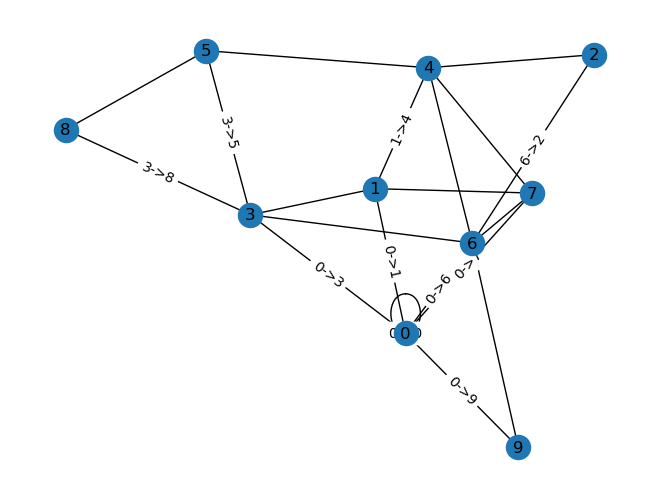

In [82]:
def visualize_bfs_tree(A, pi):
    G = nx.from_numpy_array(A)
    edges = [(pi[i], i) for i in range(len(pi)) if pi[i] != -1]
    G.add_edges_from(edges)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(pi[i], i): f'{pi[i]}->{i}' for i in range(len(pi)) if pi[i] != -1})
    return G

visualize_bfs_tree(A, pi)

In [66]:
def bfs_mod(A, s):
    # apply bfs but pi + hints (each step result)
    n = len(A)
    hints = []
    # use bfs 
    for i in range(n):  
        bfs__ = bfs(A, i)
        pi, probes = bfs__
        hints.append((pi))
    return hints

hints = bfs_mod(A, s)

In [112]:
def get_edges_indexes(A):
    edge_indexes = [[],[]]
    """Create a 2x1 list of lists to store the indexes of the edges in the adjacency matrix."""
    for i in range(len(A)):
        for j in range(len(A)):
            if A[i][j] == 1:
                edge_indexes[0].append(i)
                edge_indexes[1].append(j)
    return edge_indexes

In [120]:
get_edges_indexes(A)
# print as a list of tuples
edges = list(zip(*get_edges_indexes(A)))
print(edges)

[(0, 1), (0, 3), (0, 6), (0, 7), (0, 9), (1, 0), (1, 3), (1, 4), (1, 7), (2, 4), (2, 6), (3, 0), (3, 1), (3, 5), (3, 6), (3, 8), (4, 1), (4, 2), (4, 5), (4, 6), (4, 7), (5, 3), (5, 4), (5, 8), (6, 0), (6, 2), (6, 3), (6, 4), (6, 7), (6, 9), (7, 0), (7, 1), (7, 4), (7, 6), (8, 3), (8, 5), (9, 0), (9, 6)]


In [144]:
def get_edges(A, pi):
    edge_indexes = get_edges_indexes(A)
    edges = np.zeros(len(edge_indexes[0]))
    for i in range(len(pi)):
        if pi[i] != -1:
            for j in range(len(edge_indexes[0])):
                if edge_indexes[1][j] == i and edge_indexes[0][j] == pi[i]:
                    edges[j] = 1
    return edges

In [71]:
import numpy as np
from clrs._src import probing
from clrs._src import specs
import chex

def bfs(A: np.ndarray, s: int) -> (np.ndarray, dict):
    """Breadth-first search (Moore, 1959)."""

    chex.assert_rank(A, 2)
    probes = probing.initialize(specs.SPECS['bfs'])

    A_pos = np.arange(A.shape[0])

    probing.push(
        probes,
        specs.Stage.INPUT,
        next_probe={
            'pos': np.copy(A_pos) * 1.0 / A.shape[0],
            's': probing.mask_one(s, A.shape[0]),
            'A': np.copy(A),
            'adj': probing.graph(np.copy(A))
        })

    reach = np.zeros(A.shape[0])
    pi = np.arange(A.shape[0])
    reach[s] = 1
    
    hints = {'reach_h': [], 'pi_h': []}  # Initialize empty hints
    
    while True:
        prev_reach = np.copy(reach)
        probing.push(
            probes,
            specs.Stage.HINT,
            next_probe={
                'reach_h': np.copy(prev_reach),
                'pi_h': np.copy(pi)
            })
        hints['reach_h'].append(np.copy(prev_reach))  # Store reachability hint
        hints['pi_h'].append(np.copy(pi))            # Store predecessor hint
        
        for i in range(A.shape[0]):
            for j in range(A.shape[0]):
                if A[i, j] > 0 and prev_reach[i] == 1:
                    if pi[j] == j and j != s:
                        pi[j] = i
                    reach[j] = 1
        if np.all(reach == prev_reach):
            break

    probing.push(probes, specs.Stage.OUTPUT, next_probe={'pi': np.copy(pi)})
    probing.finalize(probes)

    return pi, hints

In [72]:
# genearte random er graph
n = 10
p = 0.3
G = nx.erdos_renyi_graph(n, p)

# get the adjacency matrix
A = nx.to_numpy_array(G)

# apply bfs
s = 0
pi, hints = bfs(A, s)

In [73]:
hints

{'reach_h': [array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 1., 0., 0., 0., 1., 1., 1., 1.]),
  array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])],
 'pi_h': [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  array([0, 1, 0, 3, 4, 5, 0, 0, 0, 0]),
  array([0, 2, 0, 8, 6, 2, 0, 0, 0, 0])]}